# "Learning for Gold"
> "Machine learning with multiple targets"

- toc: true
- badges: true
- image: images/int2/int2-gold.jpg
- comments: true 
- author: Jordan Wilheim
- categories: [machine learning, python, multi-target, regression]

## Introduction

Let's say you've been hired by a gold extraction company. 

They're interested in developing a model that will predict the recovery of gold in their gold extraction process. We will explore the dataset, determine an appropriate error metric, and find a model that minimizes this error. 

In [1]:
# collapse
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

sns.set()

from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

STATE = 10

In [2]:
model_path = Path("../models")
file_paths = [
    Path("../datasets") / ("gold_recovery_" + name + ".csv")
    for name in ["train", "test", "full"]
]
train, X_test, full = (pd.read_csv(f) for f in file_paths)

cats = [
    "rougher.input.feed",
    "rougher.output.concentrate",
    "rougher.output.tail",
    "final.output.concentrate",
    "final.output.tail",
]

## Exploratory Data Analysis 

The following transform allows us to separate categories into individual state, statetype and mineral to better understand how share value changes in each step.

### Filtration process

In [3]:
train.columns[train.columns.str.endswith("au")]

Index(['final.output.concentrate_au', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_au', 'rougher.input.feed_au',
       'rougher.output.concentrate_au', 'rougher.output.tail_au',
       'secondary_cleaner.output.tail_au'],
      dtype='object')

### Target Leakage 

We need to make sure we don't include features that will not be available at prediction time.  

We can determine which features these are by comparing our training set with the given test set that omits certain features. 

In [4]:
# Examining the difference in columns between the training and testing set.
features = X_test.columns
train.loc[:, sorted(set(train.columns).difference(set(features)))].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_au                         16789 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_au                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
test = full.set_index("date").loc[X_test["date"]].reset_index()

In [6]:
train.shape

(16860, 87)

### Target Variable Creation

C - share of gold in concentrate right after flotation - _rougher.output.concentrate\_au_

F - share of gold in the feed before flotation - _rougher.input.feed\_au_

T - share of gold in rougher tails right after flotation - _rougher.output.tail\_au_

We're going to calculate gold recovery from the first and second process using the following function.

I've added some filtration steps if any value is zero or negative.

In [7]:
def calc_recovery(C, F, T, conv_inf=True, conv_neg=True, conv_high=True):
    rec = ((C * (F - T)) / (F * (C - T))) * 100
    if conv_inf:
        rec[np.abs(rec) == np.inf] = np.nan
    if conv_neg:
        rec[rec <= 0] = np.nan

    if conv_high:
        rec[rec >= 100] = np.nan
    return rec

In [8]:
datasets = [train, test]

types = {
    "recovery_first": [
        "rougher.output.concentrate_au",
        "rougher.input.feed_au",
        "rougher.output.tail_au",
    ],
    "recovery_final": [
        "final.output.concentrate_au",
        "rougher.output.concentrate_au",
        "final.output.tail_au",
    ],
}

for d in datasets:
    for name, cols in types.items():
        d[name] = calc_recovery(*[d[t] for t in cols])

### Missing Value Management

In order for the model to work correctly, we need to drop NA values from our target variables. 

In [9]:
train = train.loc[~train[types.keys()].isna().apply(any, axis=1)]
test = test.loc[~test[types.keys()].isna().apply(any, axis=1)]

I'm dropping the date feature, as it will not serve to improve the model. 

In [10]:
X_train, y_train = (
    train[features].drop("date", axis=1),
    train[["recovery_first", "recovery_final"]],
)
X_test, y_test = (
    test[features].drop("date", axis=1),
    test[["recovery_first", "recovery_final"]],
)

Check to ensure that it matches with calculated recovery

I'm checking to see if there are any values that aren't matching the recorded output recovery.

In [11]:
unusual_values = train.loc[
    train["recovery_first"].round(2) != train["rougher.output.recovery"].round(2),
    ["recovery_first", "rougher.output.recovery"],
]

In [12]:
unusual_values.describe()

,recovery_first,rougher.output.recovery
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


Cleaning the unusual values

In [13]:
train = train.loc[train.index.difference(unusual_values.index), :]

There's a long tail distribtion, though I'm uncertain if these values are a true phenomenon. 

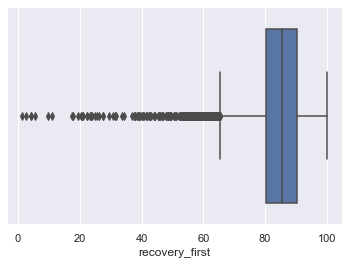

In [14]:
# collapse
sns.boxplot(train["recovery_first"])
plt.show()

There's virtually no difference between the calculated values. 

In [15]:
mean_absolute_error(train["recovery_first"], train["rougher.output.recovery"])

9.684512275848712e-15

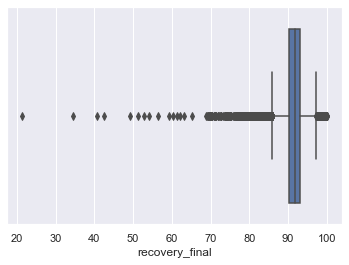

In [16]:
# collapse
sns.boxplot(train["recovery_final"])
plt.show()

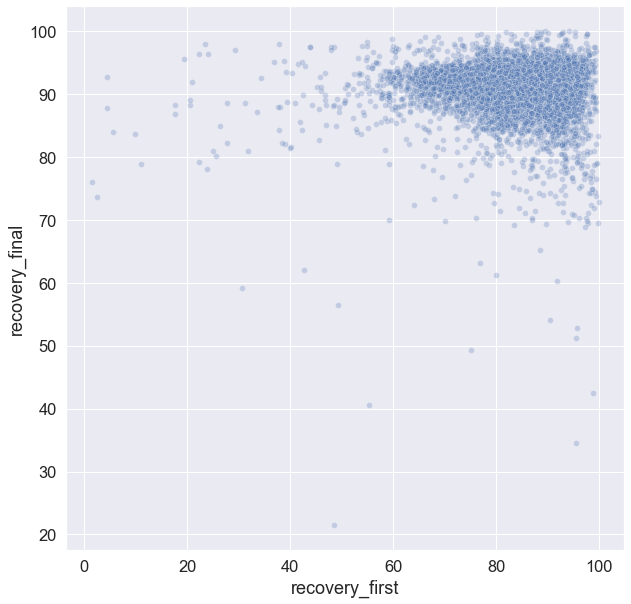

In [17]:
#collapse
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=[10,10])
    sns.scatterplot(data=train, x='recovery_first', y='recovery_final', alpha=0.25, ax=ax)

In [18]:
dfs = []
for group, col_names in types.items():
    vis_df = pd.melt(
        train[col_names], var_name="Extract Stage", value_name="Gold Concentration"
    )
    vis_df["group"] = group
    dfs.append(vis_df)
vis_df = pd.concat(dfs)

In [19]:
vis_df["Extract Stage"] = (
    vis_df["Extract Stage"]
    .str.replace("final.output.concentrate_au", "output")
    .str.replace("rougher.output.tail_au", "tails")
    .str.replace("final.output.tail_au", "tails")
    .str.replace("rougher.input.feed_au", "input")
)

vis_df.loc[
    (vis_df["group"] == "recovery_final")
    & (vis_df["Extract Stage"] == "rougher.output.concentrate_au"),
    "Extract Stage",
] = (
    "input"
)
vis_df["Extract Stage"] = vis_df["Extract Stage"].str.replace(
    "rougher.output.concentrate_au", "output"
)

order = ["input", "output", "tails"]

It looks like the final stage is much more effective at increasing the share of gold in our solution.

Because the second process is so much more effective, We can give more weight to the model that can give us a stronger prediction of a high yield at the final stage, though it's still important to properly extract gold in the first phase. 

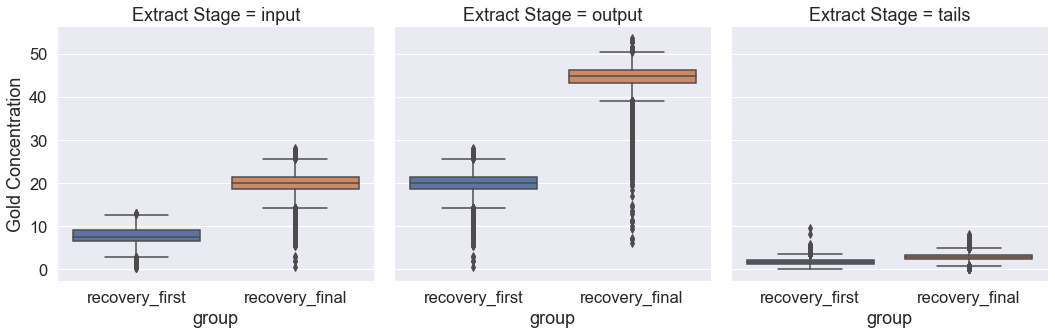

In [20]:
# collapse
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.catplot(
        x="group",
        y="Gold Concentration",
        data=vis_df,
        col="Extract Stage",
        kind="box",
        col_order=order,
    )


We can now compare metal shares throughout the purification process. 

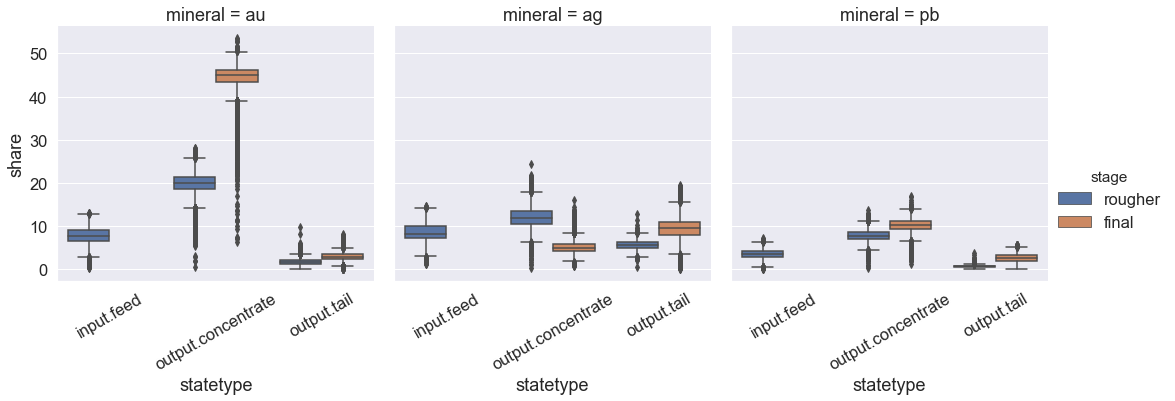

In [21]:
#collapse
ele_df = train.loc[:, train.columns.str.match("|".join(cats))].melt(
    var_name="name", value_name="share"
)
pattern = r"(?P<stage>\w+)\.(?P<statetype>\w+\.\w+)_(?P<mineral>\w\w)"
ele_df = ele_df.join(ele_df["name"].str.extract(pattern)).drop("name", axis=1)

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.catplot(
        kind="box",
        hue="stage",
        y="share",
        data=ele_df,
        col_order=["au", "ag", "pb"],
        x="statetype",
        col="mineral",
        hue_order=["rougher", "final"],
        order=["input.feed", "output.concentrate", "output.tail"],
    )
    g.set_xticklabels(rotation=30)
    

In [22]:
# collapse
ele_df.loc[ele_df["mineral"] == "au"].groupby(
    ["statetype", "stage", "mineral"]
).describe()

share                                 \
                                      count       mean       std       min   
statetype          stage   mineral                                           
input.feed         rougher au       13715.0   7.835893  1.942656  0.371753   
output.concentrate final   au       13715.0  44.309412  3.405747  6.225457   
                   rougher au       13715.0  19.853544  2.455382  0.570819   
output.tail        final   au       13715.0   2.920422  0.878378  0.005462   
                   rougher au       13715.0   1.749301  0.708658  0.020676   

                                                                                
                                          25%        50%        75%        max  
statetype          stage   mineral                                              
input.feed         rougher au        6.575086   7.627682   9.051922  13.126043  
output.concentrate final   au       43.305457  44.875340  46.156239  53.611374  
                   rougher au       18.557605  19.997707  21.417064  28.146838  
output.tail        final   au        2.369096   2.842094   3.420285   8.197408  
                   rougher au        1.303541   1.737317   2.181836   9.688980

Here we can observe how the process creating a higher share of gold as it is processed, while the other minerals have a higher share in the tails. 

There also seems to be some long tails with the output.concentrate of au. It's worth interrogating these outliers.

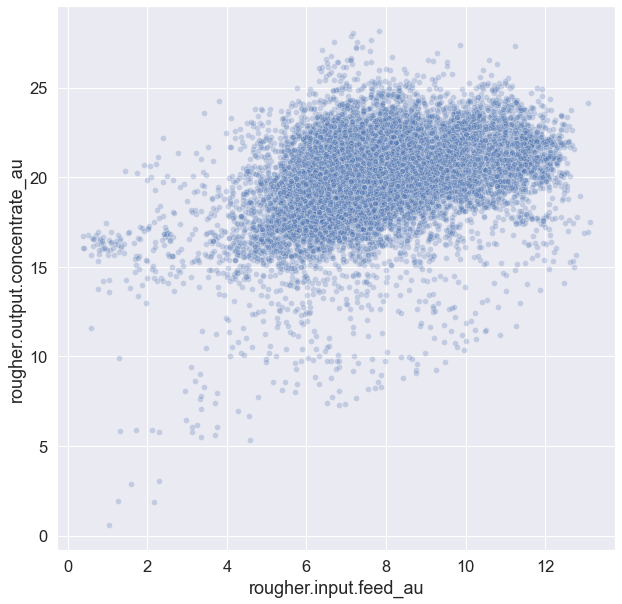

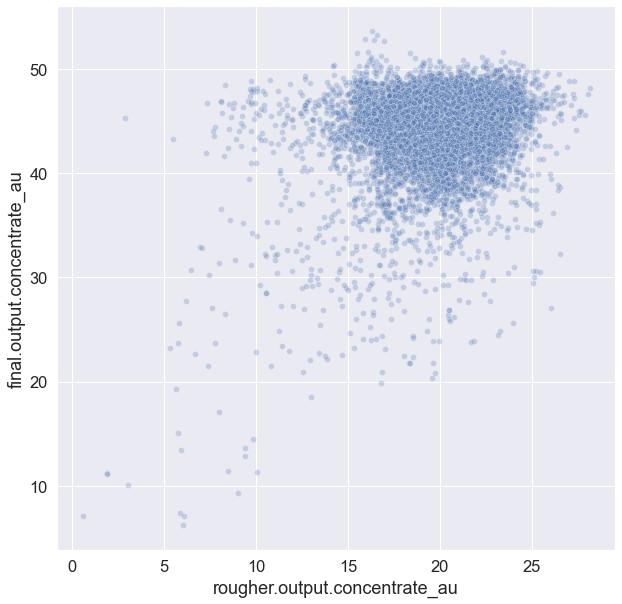

In [23]:
#collapse
scatter_dat = train.loc[:, train.columns.str.match("|".join(cats))]
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=[10,10])
    g = sns.scatterplot(data=scatter_dat, x="rougher.input.feed_au", y="rougher.output.concentrate_au", ax=ax, alpha=0.25)
    plt.show()
    
    fig, ax = plt.subplots(figsize=[10,10])
    g = sns.scatterplot(data=scatter_dat, x="rougher.output.concentrate_au", y="final.output.concentrate_au", ax=ax, alpha=0.25)
    plt.show()

When comparing feed size distribution between training and testing, I don't see any major differences in the distributions. 

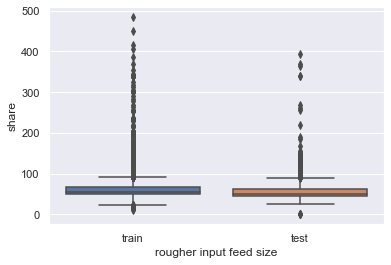

In [24]:
#collapse
comp_feed = pd.concat(
    [train["rougher.input.feed_size"], test["rougher.input.feed_size"]], axis=1
)
comp_feed.columns = ["train", "test"]
comp_feed = pd.melt(comp_feed, var_name="rougher input feed size", value_name="share")
sns.boxplot(data=comp_feed, x="rougher input feed size", y="share")
plt.show()

## Machine Learning

In [25]:
def calc_smape(y: np.array, y_pred: np.array) -> float:
    """Symmetric Mean Absolute Percentage Error"""
    smape_s = (
        np.mean(
            (
                np.abs(y_pred - y)
                / ((np.abs(y) + np.abs(y_pred)) / 2)
            )
        )
        * 100
    )

    return smape_s

def smape_score(y: np.array, y_pred: np.array) -> float:
    """Combine the """
    smape_r = calc_smape(y[:, 0], y_pred[:, 0])
    smape_f = calc_smape(y[:, 1], y_pred[:, 1])
    final_score = smape_r * 0.25 + smape_f * 0.75
    return final_score

Here's what our target and training data look like. 

In [26]:
y_train.head()

,recovery_first,recovery_final
0,87.107763,93.944554
1,86.843261,93.790501
2,86.842308,93.509750
3,87.226430,93.595268
4,86.688794,93.811976


In [27]:
X_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Now that we have a preprocessing plan, lets experiment with two algorithms. 
    
    
    - A stochastic gradient decent algorithm with a grid search of reasonable hyperparameters.
    - A random forest with 200 estimators.

In [28]:
prep = make_pipeline(SimpleImputer(), StandardScaler())

rf = make_pipeline(SimpleImputer(), RandomForestRegressor(random_state=STATE))
lin = make_pipeline(prep, MultiOutputRegressor(SGDRegressor(random_state=STATE)))

Here's what the grid search looks like. Luckly, SGD can be very quick and we can rapidly search through our parameters.

In [29]:
#collapse
#!rm ../models/lin_search.joblib
lhparams = {
    "multioutputregressor__estimator__alpha": 10.0 ** -np.arange(1, 7),
    "multioutputregressor__estimator__penalty": ["l2", "l1", "elasticnet"],
    "multioutputregressor__estimator__loss": [
        "huber",
        "squared_loss",
        "epsilon_insensitive",
    ],
    "pipeline__simpleimputer__strategy": ["mean", "median"],
}

try:
    lin_search = load(model_path / "lin_search.joblib")
except:
    lin_search = GridSearchCV(
        lin,
        lhparams,
        scoring=make_scorer(smape_score, greater_is_better=False),
        cv=5,
        n_jobs=-1,
    )
    lin_search.fit(X_train, y_train.values)
    dump(lin_search, model_path / "lin_search.joblib")

print(f"Our best linear model produced a symmetric mean absolute error of {-lin_search.best_score_:.2f} percent on the mean validation score")

Our best linear model produced a symmetric mean absolute error of 3.11 percent on the mean validation score


We can see the params from our search as well:

In [30]:
#collapse
lin_search.best_params_

{'multioutputregressor__estimator__alpha': 0.1,
 'multioutputregressor__estimator__loss': 'epsilon_insensitive',
 'multioutputregressor__estimator__penalty': 'l2',
 'pipeline__simpleimputer__strategy': 'median'}

To see if it's worth experimenting with a random forest algorithm, let's try using one and seeing how well it compares to our best linear model. 

In [31]:
from sklearn.model_selection import cross_validate

rf_pipe = make_pipeline(
    SimpleImputer(), RandomForestRegressor(n_estimators=200, random_state=STATE)
)
rf_cv = cross_validate(
    rf_pipe,
    X=X_train,
    y=y_train.values,
    cv=5,
    scoring=make_scorer(smape_score, greater_is_better=False),
    n_jobs=-1,
)

The random forest regressor isn't producing very good validation scores. Let's stick with our best linear model. 

In [32]:
rf_cv

{'fit_time': array([248.30114698, 252.9300909 , 235.06526303, 250.62381983,
        159.77804089]),
 'score_time': array([0.19062209, 0.19019198, 0.26905203, 0.2250073 , 0.10613608]),
 'test_score': array([-3.66719515, -3.94836679, -2.52269754, -3.7446072 , -4.82376732])}

We can also determine a baseline to see how much more effective our best predictor is. 

In [33]:
#collapse
dummy_score = DummyRegressor(strategy='median')
dummy_score.fit(X=X_train, y=y_train.values)
dum_pred = dummy_score.predict(X_test)

print(f"""Our baseline using the median score of our training data
yields a SMAPE of: {smape_score(y=y_test.values, y_pred=dum_pred):.2f}% on the test dataset""")

Our baseline using the median score of our training data
yields a SMAPE of: 2.94% on the test dataset


## Conclusion

In [34]:
#collapse
test_score = lin_search.score(X_test, y_test.values)
print(f"""Our best linear model produced a symmetric mean absolute error of:
      {-test_score:.2f}% on our testing dataset""")

Our best linear model produced a symmetric mean absolute error of:
      2.49% on our testing dataset


We're able to get a slight improvement on recovery using our linear model, but not by much. 

If we're not satisfied with this score, it may be worth experimenting with more advanced imputation techniques, more complex models, and feature selection and engineering. 